#Download dataset

In [1]:
!rm -r sample_data

!gdown 1uSI1i94To-ERKB94QxBdltWgQGuBwPgO
!unzip sale_data.zip
!rm -r sale_data.zip

Downloading...
From: https://drive.google.com/uc?id=1uSI1i94To-ERKB94QxBdltWgQGuBwPgO
To: /content/sale_data.zip
100% 36.8k/36.8k [00:00<00:00, 68.7MB/s]
Archive:  sale_data.zip
  inflating: supermarket_sales - Sheet1.csv  


In [17]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns
from datetime import datetime, date, time, timedelta
from sklearn.cluster import KMeans
from sklearn.preprocessing import MinMaxScaler

import numpy as np
from sklearn.neighbors import LocalOutlierFactor
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from mpl_toolkits.mplot3d import Axes3D

import plotly.express as px
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Dense, Dropout

In [4]:
sup = pd.read_csv('supermarket_sales - Sheet1.csv')
print(sup.shape)
sup.head()

(1000, 17)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


#Preprocessing

In [5]:
#convert str to datetime
sup['Date'] = pd.to_datetime(sup['Date'])
sup['Time'] = pd.to_datetime(sup['Time'])

#add hour columns
sup['Hour'] = (sup['Time']).dt.hour

# Convert to day name
sup['day_name'] = sup['Date'].dt.strftime('%A')

In [7]:
#remove unnecessary columns
sup = sup.drop(['Invoice ID','City','Tax 5%', 'Total', 'Date','Time', 'cogs', 'gross income','gross margin percentage'], axis=1)

# necessary columns [Branch, Customer type,	Gender,	Product line,	Unit price,	Quantity,	Payment,	Rating,	Hour,	day_name]

In [8]:
sup.head()

,Branch,Customer type,Gender,Product line,Unit price,Quantity,Payment,Rating,Hour,day_name
0,A,Member,Female,Health and beauty,74.69,7,Ewallet,9.1,13,Saturday
1,C,Normal,Female,Electronic accessories,15.28,5,Cash,9.6,10,Friday
2,A,Normal,Male,Home and lifestyle,46.33,7,Credit card,7.4,13,Sunday
3,A,Member,Male,Health and beauty,58.22,8,Ewallet,8.4,20,Sunday
4,A,Normal,Male,Sports and travel,86.31,7,Ewallet,5.3,10,Friday


In [9]:
#convert categorical columns to numerical
categorical_columns = [i for i in sup.columns if sup[i].dtype == 'object']

print(categorical_columns)

for i in categorical_columns:
    sup[i] = sup[i].astype('category').cat.codes + 1

['Branch', 'Customer type', 'Gender', 'Product line', 'Payment', 'day_name']


In [12]:
#normalizing the data between 0-1
scaler = MinMaxScaler()

numerical_columns = sup.columns
sup[numerical_columns] = scaler.fit_transform(sup[numerical_columns])

In [13]:
sup.corr().style.background_gradient("copper_r")

,Branch,Customer type,Gender,Product line,Unit price,Quantity,Payment,Rating,Hour,day_name
Branch,1.000000,-0.019608,-0.056318,-0.053938,0.028202,0.015964,-0.050104,0.010238,0.033007,0.050133
Customer type,-0.019608,1.000000,0.039996,-0.036800,-0.020238,-0.016763,0.018073,0.018889,-0.018893,-0.054156
Gender,-0.056318,0.039996,1.000000,0.005193,0.015445,-0.074258,0.044578,0.004800,0.084081,0.015110
Product line,-0.053938,-0.036800,0.005193,1.000000,0.019321,0.020256,0.029896,-0.020529,-0.060850,-0.012443
Unit price,0.028202,-0.020238,0.015445,0.019321,1.000000,0.010778,-0.015941,-0.008778,0.008242,-0.026200
Quantity,0.015964,-0.016763,-0.074258,0.020256,0.010778,1.000000,-0.003921,-0.015815,-0.007317,0.021211
Payment,-0.050104,0.018073,0.044578,0.029896,-0.015941,-0.003921,1.000000,-0.005381,0.045421,0.033831
Rating,0.010238,0.018889,0.004800,-0.020529,-0.008778,-0.015815,-0.005381,1.000000,-0.030588,-0.043913
Hour,0.033007,-0.018893,0.084081,-0.060850,0.008242,-0.007317,0.045421,-0.030588,1.000000,0.004519
day_name,0.050133,-0.054156,0.015110,-0.012443,-0.026200,0.021211,0.033831,-0.043913,0.004519,1.000000


In [15]:
pca = PCA(n_components=3)
reduced_data = pca.fit_transform(sup)
print(reduced_data.shape)
reduced_data

(1000, 3)


array([[-0.58649007, -0.09897872,  0.79001142],
       [-0.16466387,  0.86027129, -0.65923139],
       [ 0.7295666 ,  0.05076706,  0.22219731],
       ...,
       [ 0.09458299, -0.67658995, -0.18868079],
       [ 0.73631187,  0.0589548 , -0.17825988],
       [-0.69536883, -0.0182779 , -0.0466752 ]])

#K-means clustering

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


     Feature1  Feature2  Feature3  Cluster
0   -0.586490 -0.098979  0.790011        0
1   -0.164664  0.860271 -0.659231        0
2    0.729567  0.050767  0.222197        0
3    0.181992 -0.784495  0.610956        0
4    0.776006  0.050375  0.636548        0
..        ...       ...       ...      ...
995  0.700982  0.037059  0.010856        0
996 -0.028182  0.651276  0.495390        0
997  0.094583 -0.676590 -0.188681        0
998  0.736312  0.058955 -0.178260        0
999 -0.695369 -0.018278 -0.046675        0

[1000 rows x 4 columns]


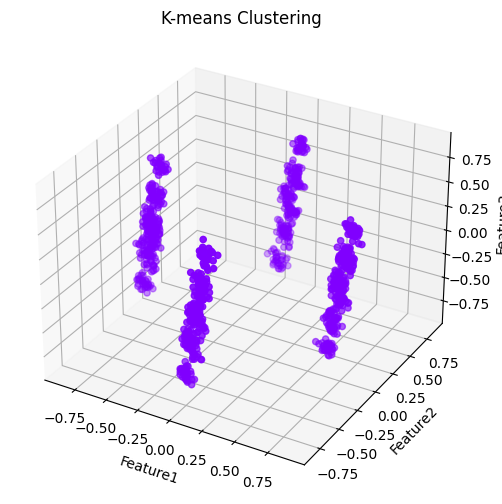

In [16]:
data = {'Feature1': reduced_data[:, 0],
        'Feature2': reduced_data[:, 1],
        'Feature3': reduced_data[:, 2]}
df = pd.DataFrame(data)

num_clusters = 1

features_for_clustering = df[['Feature1', 'Feature2', 'Feature3']]

kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['Cluster'] = kmeans.fit_predict(features_for_clustering)

print(df)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(df['Feature1'], df['Feature2'], df['Feature3'], c=df['Cluster'], cmap='rainbow')
ax.set_xlabel('Feature1')
ax.set_ylabel('Feature2')
ax.set_zlabel('Feature3')
plt.title('K-means Clustering')
plt.show()

#Forecasting model

In [45]:
#read again dataset
sup = pd.read_csv('supermarket_sales - Sheet1.csv')
print(sup.shape)
sup.head()

(1000, 17)


,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3


In [46]:
predict_df = sup[['Date', 'gross income']]
#convert str to datetime
predict_df['Date'] = pd.to_datetime(predict_df['Date'])

closedf = predict_df.sort_values(by='Date')

print("Shape of dataframe:", predict_df.shape)

Shape of dataframe: (1000, 2)


<ipython-input-46-93ed35904e67>:3: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [47]:
fig = px.line(closedf, x=closedf.Date, y=closedf['gross income'],labels={'Date':'Date','gross income':'gross income'})
fig.update_traces(marker_line_width=2, opacity=0.8, marker_line_color='orange')
fig.update_layout(title_text='Whole period of income', plot_bgcolor='white',
                  font_size=15, font_color='black')
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

In [48]:
close_stock = closedf.copy()
closedf.head()

,Date,gross income
856,2019-01-01,8.448
567,2019-01-01,29.583
245,2019-01-01,19.036
696,2019-01-01,5.408
523,2019-01-01,6.287


In [49]:
del closedf['Date']
scaler=MinMaxScaler(feature_range=(0,1))
closedf=scaler.fit_transform(np.array(closedf).reshape(-1,1))
print(closedf.shape)

(1000, 1)


In [50]:

training_size=int(len(closedf)*0.80)
test_size=len(closedf)-training_size
train_data,test_data=closedf[0:training_size,:],closedf[training_size:len(closedf),:1]
print("train_data: ", train_data.shape)
print("test_data: ", test_data.shape)

train_data:  (800, 1)
test_data:  (200, 1)


In [51]:
def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step-1):
        a = dataset[i:(i+time_step), 0]   ###i=0, 0,1,2,3-----99   100
        dataX.append(a)
        dataY.append(dataset[i + time_step, 0])
    return np.array(dataX), np.array(dataY)

In [52]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (784, 15)
y_train:  (784,)
X_test:  (184, 15)
y_test (184,)


In [53]:
X_train =X_train.reshape(X_train.shape[0],X_train.shape[1] , 1)
X_test = X_test.reshape(X_test.shape[0],X_test.shape[1] , 1)

print("X_train: ", X_train.shape)
print("X_test: ", X_test.shape)

X_train:  (784, 15, 1)
X_test:  (184, 15, 1)


**LSTM**

In [54]:
model=Sequential()

model.add(LSTM(10,input_shape=(None,1),activation="relu"))

model.add(Dense(1))

model.compile(loss="mean_squared_error",optimizer="adam")

In [55]:
history = model.fit(X_train,y_train,validation_data=(X_test,y_test),epochs=200,batch_size=32,verbose=1)

Epoch 1/200
25/25 [==============================] - 2s 18ms/step - loss: 0.1497 - val_loss: 0.1278
Epoch 2/200
25/25 [==============================] - 0s 7ms/step - loss: 0.1217 - val_loss: 0.1050
Epoch 3/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0990 - val_loss: 0.0844
Epoch 4/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0760 - val_loss: 0.0597
Epoch 5/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0580 - val_loss: 0.0569
Epoch 6/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0578 - val_loss: 0.0563
Epoch 7/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0580 - val_loss: 0.0564
Epoch 8/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0576 - val_loss: 0.0563
Epoch 9/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0576 - val_loss: 0.0563
Epoch 10/200
25/25 [==============================] - 0s 7ms/step - loss: 0.0578 - val_loss: 0.0564
Epoch 11

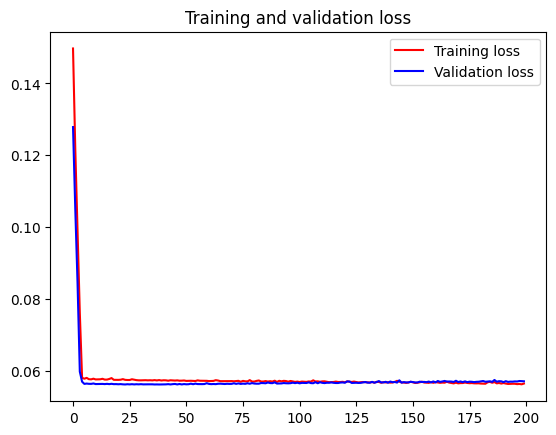

<Figure size 640x480 with 0 Axes>

In [56]:
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend(loc=0)
plt.figure()


plt.show()

In [57]:
train_predict=model.predict(X_train)
test_predict=model.predict(X_test)
train_predict.shape, test_predict.shape

6/6 [==============================] - 0s 3ms/step


((784, 1), (184, 1))

In [58]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [59]:
import os
import math
import matplotlib.pyplot as plt

from sklearn.metrics import mean_squared_error, mean_absolute_error, explained_variance_score, r2_score
from sklearn.metrics import mean_poisson_deviance, mean_gamma_deviance, accuracy_score

# For PLotting we will use these library
from itertools import cycle
import plotly.graph_objects as go
from plotly.subplots import make_subplots

In [60]:
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Train data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("-------------------------------------------------------------------------------------")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  11.648358932312371
Train data MSE:  135.6842658159814
Train data MAE:  9.557846551418304
-------------------------------------------------------------------------------------
Test data RMSE:  11.736340666438968
Test data MSE:  137.74169223870908
Test data MAE:  9.695959313517031


In [61]:
print("Train data explained variance regression score:",
      explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:",
      explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.023132329212673386
Test data explained variance regression score: -0.011939453011240664


In [62]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.022373168209605665
Test data R2 score: -0.011947021099939947


In [63]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.7034150727920337
Test data MGD:  0.7078397111349501
----------------------------------------------------------------------
Train data MPD:  8.577014899350996
Test data MPD:  8.778925573203725


In [64]:
look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original income','Train predicted inccome','Test predicted income'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_income': close_stock['gross income'],
                      'train_predicted_income': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_income': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_income'],plotdf['train_predicted_income'],
                                          plotdf['test_predicted_income']],
              labels={'value':'income','date': 'Date'})
fig.update_layout(title_text='Comparision between original income vs predicted income',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Gross income')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1000, 1)
Test predicted data:  (1000, 1)


In [65]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_days = 10
while(i<pred_days):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input = x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))

        yhat = model.predict(x_input, verbose=0)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)

        lst_output.extend(yhat.tolist())
        i=i+1

    else:

        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        temp_input.extend(yhat[0].tolist())

        lst_output.extend(yhat.tolist())
        i=i+1

print("Output of predicted next days: ", len(lst_output))

Output of predicted next days:  10


In [66]:
last_days=np.arange(1,time_step+1)
day_pred=np.arange(time_step+1,time_step+pred_days+1)
print(last_days)
print(day_pred)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15]
[16 17 18 19 20 21 22 23 24 25]


In [67]:
temp_mat = np.empty((len(last_days)+pred_days+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

new_pred_plot = pd.DataFrame({
    'last_original_days_value':last_original_days_value,
    'next_predicted_days_value':next_predicted_days_value
})

names = cycle(['Last 15 days income','Predicted next 10 days income'])

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_days_value'],
                                                      new_pred_plot['next_predicted_days_value']],
              labels={'value': 'Gross income','index': 'Timestamp'})
fig.update_layout(title_text='Compare last 15 days vs next 10 predict days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Gross income')

fig.for_each_trace(lambda t:  t.update(name = next(names)))
fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

**Random forest regression**

In [68]:
time_step = 15
X_train, y_train = create_dataset(train_data, time_step)
X_test, y_test = create_dataset(test_data, time_step)

print("X_train: ", X_train.shape)
print("y_train: ", y_train.shape)
print("X_test: ", X_test.shape)
print("y_test", y_test.shape)

X_train:  (784, 15)
y_train:  (784,)
X_test:  (184, 15)
y_test (184,)


In [69]:
from sklearn.ensemble import RandomForestRegressor

time_step = 15
regressor = RandomForestRegressor(n_estimators = 100, random_state = 0)
regressor.fit(X_train, y_train)

RandomForestRegressor(random_state=0)

In [70]:
# Prediction
train_predict=regressor.predict(X_train)
test_predict=regressor.predict(X_test)

train_predict = train_predict.reshape(-1,1)
test_predict = test_predict.reshape(-1,1)

print("Train data prediction:", train_predict.shape)
print("Test data prediction:", test_predict.shape)

Train data prediction: (784, 1)
Test data prediction: (184, 1)


In [71]:
# Transform back to original form

train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)
original_ytrain = scaler.inverse_transform(y_train.reshape(-1,1))
original_ytest = scaler.inverse_transform(y_test.reshape(-1,1))

In [72]:
# Evaluation metrices RMSE and MAE
print("Train data RMSE: ", math.sqrt(mean_squared_error(original_ytrain,train_predict)))
print("Train data MSE: ", mean_squared_error(original_ytrain,train_predict))
print("Test data MAE: ", mean_absolute_error(original_ytrain,train_predict))
print("\n")
print("Test data RMSE: ", math.sqrt(mean_squared_error(original_ytest,test_predict)))
print("Test data MSE: ", mean_squared_error(original_ytest,test_predict))
print("Test data MAE: ", mean_absolute_error(original_ytest,test_predict))

Train data RMSE:  4.483783636343539
Train data MSE:  20.104315697542084
Test data MAE:  3.6629425765306114


Test data RMSE:  11.776619599789367
Test data MSE:  138.68876919814306
Test data MAE:  9.645068614130436


In [73]:
print("Train data explained variance regression score:", explained_variance_score(original_ytrain, train_predict))
print("Test data explained variance regression score:", explained_variance_score(original_ytest, test_predict))

Train data explained variance regression score: 0.855359599273414
Test data explained variance regression score: -0.015198417478560211


In [74]:
print("Train data R2 score:", r2_score(original_ytrain, train_predict))
print("Test data R2 score:", r2_score(original_ytest, test_predict))

Train data R2 score: 0.8551451906195378
Test data R2 score: -0.018904912296678678


In [75]:
print("Train data MGD: ", mean_gamma_deviance(original_ytrain, train_predict))
print("Test data MGD: ", mean_gamma_deviance(original_ytest, test_predict))
print("----------------------------------------------------------------------")
print("Train data MPD: ", mean_poisson_deviance(original_ytrain, train_predict))
print("Test data MPD: ", mean_poisson_deviance(original_ytest, test_predict))

Train data MGD:  0.2236969792332941
Test data MGD:  0.7160832107723966
----------------------------------------------------------------------
Train data MPD:  1.5720856218023007
Test data MPD:  8.856883138550227


In [81]:
# shift train predictions for plotting

look_back=time_step
trainPredictPlot = np.empty_like(closedf)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(train_predict)+look_back, :] = train_predict
print("Train predicted data: ", trainPredictPlot.shape)

# shift test predictions for plotting
testPredictPlot = np.empty_like(closedf)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(train_predict)+(look_back*2)+1:len(closedf)-1, :] = test_predict
print("Test predicted data: ", testPredictPlot.shape)

names = cycle(['Original income','Train predicted income','Test predicted income'])


plotdf = pd.DataFrame({'date': close_stock['Date'],
                       'original_income': close_stock['gross income'],
                      'train_predicted_income': trainPredictPlot.reshape(1,-1)[0].tolist(),
                      'test_predicted_income': testPredictPlot.reshape(1,-1)[0].tolist()})

fig = px.line(plotdf,x=plotdf['date'], y=[plotdf['original_income'],plotdf['train_predicted_income'],
                                          plotdf['test_predicted_income']],
              labels={'value':'Gross income','date': 'Date'})
fig.update_layout(title_text='Comparision between original income vs predicted income',
                  plot_bgcolor='white', font_size=15, font_color='black', legend_title_text='Gross income')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()

Train predicted data:  (1000, 1)
Test predicted data:  (1000, 1)


In [80]:
x_input=test_data[len(test_data)-time_step:].reshape(1,-1)
temp_input=list(x_input)
temp_input=temp_input[0].tolist()
print(temp_input)
from numpy import array

lst_output=[]
n_steps=time_step
i=0
pred_mins = 10
while(i<pred_mins):

    if(len(temp_input)>time_step):

        x_input=np.array(temp_input[1:])
        #print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)

        yhat = regressor.predict(x_input)
        #print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat.tolist())
        temp_input=temp_input[1:]

        lst_output.extend(yhat.tolist())
        i=i+1

    else:
        yhat = regressor.predict(x_input)

        temp_input.extend(yhat.tolist())
        lst_output.extend(yhat.tolist())

        i=i+1

print("Output of predicted next days: ", len(lst_output))

[0.7159223873915121, 0.10702766500819062, 0.2687443403233519, 0.8837031836635023, 0.27618204572509997, 0.5799477020440971, 0.17971571889339968, 0.5803546900277768, 0.4182717255273038, 0.19978022648881294, 0.8799181954152804, 0.07251508399214512, 0.2851866548640151, 0.44486839026077757, 0.31748115136900584]
Output of predicted next days:  10


In [78]:
last_dates=np.arange(1,time_step+1)
date_pred=np.arange(time_step+1,time_step+pred_mins+1)
# print(last_days)
# print(day_pred)

In [82]:
temp_mat = np.empty((len(last_dates)+pred_mins+1,1))
temp_mat[:] = np.nan
temp_mat = temp_mat.reshape(1,-1).tolist()[0]

last_original_days_value = temp_mat
next_predicted_days_value = temp_mat

last_original_days_value[0:time_step+1] = scaler.inverse_transform(closedf[len(closedf)-time_step:]).reshape(1,-1).tolist()[0]
next_predicted_days_value[time_step+1:] = scaler.inverse_transform(np.array(lst_output).reshape(-1,1)).reshape(1,-1).tolist()[0]

names = cycle(['Last 15 dates income','Predicted next 10 days income'])

new_pred_plot = pd.DataFrame({
    'last_original_dates_value':last_original_days_value,
    'next_predicted_dates_value':next_predicted_days_value
})

fig = px.line(new_pred_plot,x=new_pred_plot.index, y=[new_pred_plot['last_original_dates_value'],
                                                      new_pred_plot['next_predicted_dates_value']],
              labels={'value': 'Gross income','index': 'Timestamp'})

fig.update_layout(title_text='Compare last 15 days vs next 10 days',
                  plot_bgcolor='white', font_size=15, font_color='black',legend_title_text='Gross income')
fig.for_each_trace(lambda t:  t.update(name = next(names)))

fig.update_xaxes(showgrid=False)
fig.update_yaxes(showgrid=False)
fig.show()